# LPL on Shapes3D - Extended Data Figures 5 and 6

### Preparation
Before running the code on the Shapes3D dataset, you'll need to first download the dataset and pre-generate the required sequence of images. To do this, follow the steps below:
1. Run the script `prepare_3dshapes.sh` provided in the same directory as this notebook. This will download the dataset and extract it to `~/data/datasets/shapes3d`. If you want to change the location of the dataset, you'll need to change the `DATA_DIR` variable in the script.
3. Run `python datasets/sequence_generator.py`. This will create a large number of sequences of indices corresponding to the description in the paper. This will also create and save a random permutation of the colors in order to destroy the original ordering of the colors in the dataset.

### Training
You can then run the main script with the `--dataset shapes3d` flag. Running the commands below are sufficient to then use this notebook and reproduce the results in the paper.
```
python lpl_main.py --dataset shapes3d --learning_rate 1e-5 --max_epochs 400 --experiment_name baseline
python lpl_main.py --dataset shapes3d --learning_rate 1e-5 --max_epochs 400 --experiment_name pred_off --pull_coeff 0.0
python lpl_main.py --dataset shapes3d --learning_rate 0.0 --max_steps 1 --experiment_name random_network
```

### Evaluation
You can then run this notebook to generate the plots in the paper. 

If desired, you can also run:
```python eval.py --dataset shapes3d --experiment_dir $EXPERIMENT_DIR```
to evaluate classification accuracies with respect to each of the 6 factors of variation in the dataset. This will generate a yaml file with the results in the experiment directory similar to the evaluation in `notebooks/3 - Deep nets.ipynb`.


In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
import numpy as np
import numpy.lib as npl
import h5py
import os
import time
import yaml

from tqdm.notebook import tqdm

import torch
import torch.nn as nn

import project_path
from datasets.shapes3d_datamodule import Shapes3DDataModule
from models.module import LPL

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import accuracy_score

In [2]:
outputdir = os.path.expanduser("~/data/lpl/plots/fig_shapes3d")
os.makedirs(outputdir, exist_ok=True)

In [3]:
def show_images_grid(imgs_, num_images=25, savefig=False):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
            # no frame
            ax.set_frame_on(False)
        else:
            ax.axis('off')
    if savefig:
        # save every row of the figure in pdf format
        plt.savefig(os.path.join(outputdir, 'video_frames.pdf'), bbox_inches='tight', format='pdf')

## Data visualisation

In [ ]:
data_dir = os.path.expanduser("~/data/datasets/shapes3d")
data_module = Shapes3DDataModule(data_dir=data_dir)
data_module.prepare_data()
data_module.setup()

In [5]:
# sample a batch from the datamodule
batch = next(iter(data_module.train_dataloader()))
imgs = batch[0][0].permute(0,2,3,1)

In [ ]:
show_images_grid(imgs[:25])

The above images are from the data module that is actually used during training, and as such, the images have already been normalized by the standard deviation of the dataset. Below, you can see image sequences without the normalization by loading the original raw dataset.

In [7]:
dataset = h5py.File(os.path.join(data_dir, '3dshapes.h5'), 'r')
images = np.array(dataset['images'])  # (480000, 64, 64, 3)
factor_values = np.array(dataset['labels'])  # (480000, 6)

In [8]:
_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 'scale': 8, 'shape': 4, 'orientation': 15}

shuffle_colors = True
if shuffle_colors:
    _PERMUTATIONS_PER_FACTOR = np.load(os.path.join(data_dir, 'permutations.npy'), allow_pickle=True).item()
    indexed_trajectories = np.load(os.path.join(data_dir, 'indexed_trajectories.npy'))
else:
    _PERMUTATIONS_PER_FACTOR = {factor: np.arange(_NUM_VALUES_PER_FACTOR[factor]) for factor in _FACTORS_IN_ORDER}
    indexed_trajectories = np.load(os.path.join(data_dir, 'indexed_trajectories_no_shuffle.npy'))

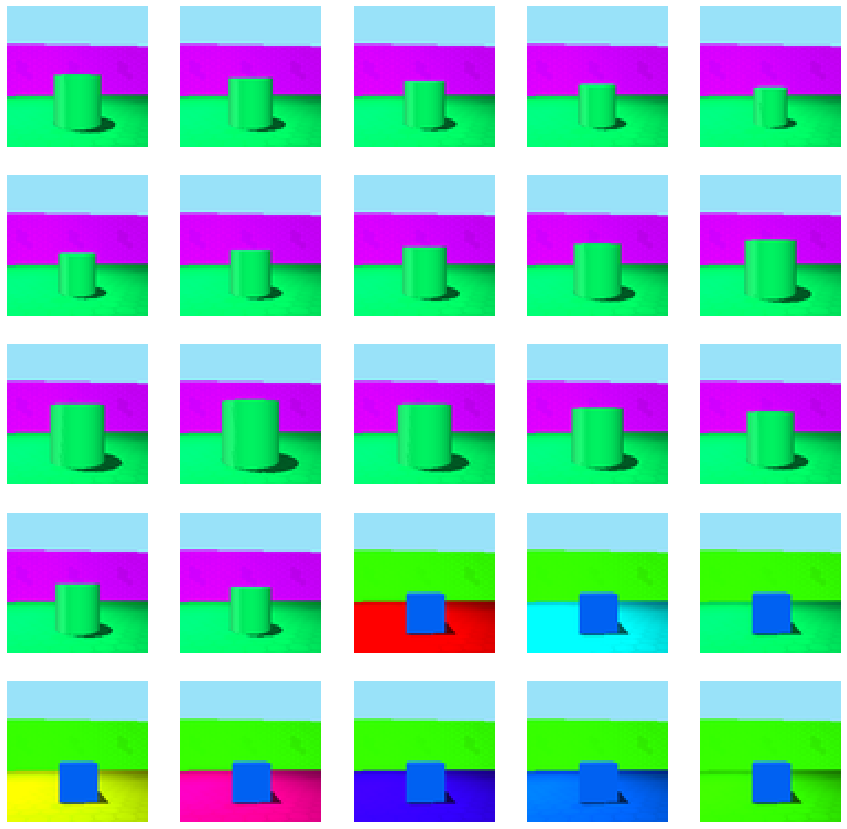

In [9]:
img_seq = images[indexed_trajectories[:25]]
show_images_grid(img_seq)

## Transition probabilities
Let's estimate the transition probabilities empirically by counting the number of times each transition occurs in the dataset. We'll use the entire set of sequences that we initially generated above.

In [10]:
labels = np.zeros_like(factor_values, dtype=np.int64)

for factor in _FACTORS_IN_ORDER:
    if factor == 'floor_hue' or factor == 'wall_hue' or factor == 'object_hue':
        labels[:, _FACTORS_IN_ORDER.index(factor)] = (factor_values[:, _FACTORS_IN_ORDER.index(factor)] * 10).astype(np.int64)
    elif factor == 'scale':
        labels[:, _FACTORS_IN_ORDER.index(factor)] = np.digitize(factor_values[:, _FACTORS_IN_ORDER.index(factor)], np.linspace(0.75, 1.25, 8)) - 1
    elif factor == 'shape':
        labels[:, _FACTORS_IN_ORDER.index(factor)] = (factor_values[:, _FACTORS_IN_ORDER.index(factor)]).astype(np.int64)
    elif factor == 'orientation':
        labels[:, _FACTORS_IN_ORDER.index(factor)] = np.digitize(factor_values[:, _FACTORS_IN_ORDER.index(factor)], np.linspace(-30, 30, 15)) - 1

flattened_trajectories = labels[indexed_trajectories]

To get an idea of how the dataset is structured, we'll also print out the different factors of variation that are present in the dataset. These are the different properties of the shapes that we can change. We'll also print out the possible labels for each factor of variation.

In [11]:
for i in range(6):
    print(_FACTORS_IN_ORDER[i])
    print(np.unique(flattened_trajectories[:, i]))

floor_hue
[0 1 2 3 4 5 6 7 8 9]
wall_hue
[0 1 2 3 4 5 6 7 8 9]
object_hue
[0 1 2 3 4 5 6 7 8 9]
scale
[0 1 2 3 4 5 6 7]
shape
[0 1 2 3]
orientation
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [12]:
# estimate one-step transition probabilities for each factor from flattened trajectories
transition_matrices = {}
for factor in _FACTORS_IN_ORDER:
    print('Estimating transition matrix for factor: {}'.format(factor))
    transition_matrices[factor] = np.zeros([_NUM_VALUES_PER_FACTOR[factor], _NUM_VALUES_PER_FACTOR[factor]], dtype=np.float32)
    for i in range(_NUM_VALUES_PER_FACTOR[factor]):
        for j in range(_NUM_VALUES_PER_FACTOR[factor]):
            # count how many times factor i is followed by factor j in flattened_trajectories
            transition_matrices[factor][i, j] = np.sum(np.logical_and(flattened_trajectories[:-1, _FACTORS_IN_ORDER.index(factor)] == i, flattened_trajectories[1:, _FACTORS_IN_ORDER.index(factor)] == j))
    # normalize to get probabilities
    transition_matrices[factor] /= np.sum(transition_matrices[factor], axis=1, keepdims=True)

Estimating transition matrix for factor: floor_hue
Estimating transition matrix for factor: wall_hue
Estimating transition matrix for factor: object_hue
Estimating transition matrix for factor: scale
Estimating transition matrix for factor: shape
Estimating transition matrix for factor: orientation


In [13]:
def refine_title(factor_name):
    # replace _ with space and capitalize first letter of first word only
    factor_name = factor_name.replace('_', ' ')
    factor_name = factor_name[0].upper() + factor_name[1:]
    return factor_name

We can see that the transition matrix for the color factors are shuffled with respect to the original ordering of the colors in the dataset. This is because we randomly permuted the colors in the dataset initially.

The next cell shows the transition matrix if we correct for this random permutation of the colors.

/tmp/ipykernel_1696758/2534448788.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


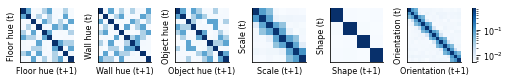

In [14]:
# plot transition matrices
fig, ax = plt.subplots(1, 6, figsize=(6.6, 1.5))
cbar_ax = fig.add_axes([1., .25, .01, .5])
for i, factor in enumerate(_FACTORS_IN_ORDER):
    sns.heatmap(transition_matrices[factor], ax=ax[i], vmin=0, vmax=1, cmap='Blues', norm=LogNorm(), cbar=i==0, cbar_ax=None if i else cbar_ax)
    # ax[i // 3, i % 3].set_title(factor)
    ax[i].set_xlabel(refine_title(factor) + ' (t+1)')
    ax[i].set_ylabel(refine_title(factor) + ' (t)')
    ax[i].set_aspect('equal')
    # turn off ticks
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].xaxis.label.set_size(8)
    ax[i].yaxis.label.set_size(8)
    if i == 0:
        cbar = ax[i].collections[0].colorbar
        cbar.ax.tick_params(labelsize=8)
        # cbar.ax.set_position([0.8, 0.1, 0.03, 0.8])
    # cbar.set_ticks([0, 1])
    sns.despine()
plt.tight_layout()
# save figure in pdf format
# fig.savefig(os.path.join(outputdir, 'transition_matrices_unsorted.pdf'), format='pdf', bbox_inches='tight', backend='pgf')

/tmp/ipykernel_1696758/500712672.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


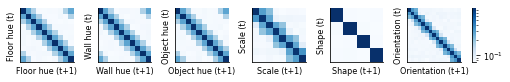

In [15]:
# plot transition matrices taking into account the permutations
fig, ax = plt.subplots(1, 6, figsize=(6.6, 1.5))
cbar_ax = fig.add_axes([1., .25, .01, .5])
for i, factor in enumerate(_FACTORS_IN_ORDER):
    sns.heatmap(np.sqrt(transition_matrices[factor][_PERMUTATIONS_PER_FACTOR[factor], :][:, _PERMUTATIONS_PER_FACTOR[factor]]), ax=ax[i], vmin=0, vmax=1, cmap='Blues', norm=LogNorm(), cbar=i==0, cbar_ax=None if i else cbar_ax)
    # ax[i // 3, i % 3].set_title(factor)
    ax[i].set_xlabel(refine_title(factor) + ' (t+1)')
    ax[i].set_ylabel(refine_title(factor) + ' (t)')
    ax[i].set_aspect('equal')
    # turn off ticks
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].xaxis.label.set_size(8)
    ax[i].yaxis.label.set_size(8)
    if i == 0:
        cbar = ax[i].collections[0].colorbar
        cbar.ax.tick_params(labelsize=8)
        # cbar.ax.set_position([0.8, 0.1, 0.03, 0.8])
    # cbar.set_ticks([0, 1])
    sns.despine()
plt.tight_layout()
# save figure in pdf format
# fig.savefig(os.path.join(outputdir, 'transition_matrices.pdf'), format='pdf', bbox_inches='tight', backend='pgf')

## Representational (dis)similarity matrices 
We'll now compare the transition probability matrix with the representational similarity matrix (RSM) of the learned representations as well as a few baselines. The RSM is a matrix of averaged pairwise similarities between the representations of each factor.

In [16]:
class FlatView(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.reshape(x.size(0), -1), None, None

In [17]:
images = torch.from_numpy(images) / 255.0
labels = torch.from_numpy(labels)

standardize_pixels = True
if standardize_pixels:
    images = (images - images.mean(dim=(0,1,2), keepdim=True)) / images.std(dim=(0,1,2), keepdim=True)
images = images.permute(0,3,1,2) # shape (batch_size, 3, 64, 64)

### Loading network models
Change the experiment paths below in case you didn't use the default experiment names provided above.

In [ ]:
lpl_experiment_path = os.path.expanduser('~/data/lpl/shapes3d/baseline/lpl')
# get the only .ckpt file
lpl_model_path = os.path.join(lpl_experiment_path, 'checkpoints', os.listdir(os.path.join(lpl_experiment_path, 'checkpoints'))[0])
lpl_model = LPL.load_from_checkpoint(lpl_model_path, strict=False).to('cuda')
lpl_net = lpl_model.network

pred_off_experiment_path = os.path.expanduser('~/data/lpl/shapes3d/pred_off/lpl')
# get the only .ckpt file
pred_off_model_path = os.path.join(pred_off_experiment_path, 'checkpoints', os.listdir(os.path.join(pred_off_experiment_path, 'checkpoints'))[0])
pred_off_model = LPL.load_from_checkpoint(pred_off_model_path, strict=False).to('cuda')
pred_off_net = pred_off_model.network

random_experiment_path = os.path.expanduser('~/data/lpl/shapes3d/random_network/lpl')
# get the only .ckpt file
random_model_path = os.path.join(random_experiment_path, 'checkpoints', os.listdir(os.path.join(random_experiment_path, 'checkpoints'))[0])
random_model = LPL.load_from_checkpoint(random_model_path, strict=False).to('cuda')
random_net = random_model.network

pixel_net = FlatView().to('cuda')

### Helper functions

In [19]:
# methods for sampling unconditionally/conditionally on a given factor
def get_index(factors):
  """ Converts factors to indices in range(num_data)
  Args:
    factors: np array shape [6,batch_size].
             factors[i]=factors[i,:] takes integer values in 
             range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

  Returns:
    indices: np array shape [batch_size].
  """
  indices = 0
  base = 1
  for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
    indices += factors[factor] * base
    base *= _NUM_VALUES_PER_FACTOR[name]
  return indices


def sample_random_batch(batch_size, fixed_factor=None, fixed_factor_value=None):
  """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
      the other factors varying randomly.
  Args:
    batch_size: number of images to sample.
    fixed_factor: index of factor that is fixed in range(6).
    fixed_factor_value: integer value of factor that is fixed 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

  Returns:
    batch: images shape [batch_size,64,64,3]
    factors: factors shape [6,batch_size].
  """
  factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                     dtype=np.int32)
  for factor, name in enumerate(_FACTORS_IN_ORDER):
    num_choices = _NUM_VALUES_PER_FACTOR[name]
    factors[factor] = np.random.choice(num_choices, batch_size)
  if fixed_factor is not None:
        assert fixed_factor_value is not None
        factors[fixed_factor] = fixed_factor_value
  indices = get_index(factors)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  return ims, factors
  
def sample_batch_varying_one_factor(factor, other_factor_values, preshuffled=True):
    """ Samples a batch of images with factor varying from 0 to _NUM_VALUES_PER_FACTOR[factor]-1,
    the other factors fixed to other_factor_values.
    Args:
        factor: name of factor that is varied in range(_NUM_VALUES_PER_FACTOR).
        other_factor_values: np array shape [6] of integer values of factors that are fixed 
            in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[factor]]) with the varying factor being overwritten.
    Returns:
        batch: images shape [_NUM_VALUES_PER_FACTOR[factor],64,64,3]
    """
    factors = np.zeros([len(_FACTORS_IN_ORDER), _NUM_VALUES_PER_FACTOR[factor]], dtype=np.int32)
    for i in range(len(other_factor_values)):
        factors[i] = other_factor_values[i]
    # factors[_FACTORS_IN_ORDER.index(factor)] = np.arange(_NUM_VALUES_PER_FACTOR[factor])
    
    if preshuffled:
      # shuffle columns of factors according to permutation_indices of corresponding factor
      factors[_FACTORS_IN_ORDER.index(factor)] = _PERMUTATIONS_PER_FACTOR[factor]
      # factors = factors[:, permutation_indices[factor]]
    else:
      factors[_FACTORS_IN_ORDER.index(factor)] = np.arange(_NUM_VALUES_PER_FACTOR[factor])

    indices = get_index(factors)
    ims = []
    for ind in indices:
        im = images[ind]
        im = np.asarray(im)
        ims.append(im)
    ims = np.stack(ims, axis=0)
    return ims, factors

In [20]:
def cosine_similarity(x, y):
    x_norm = np.linalg.norm(x, axis=1)
    y_norm = np.linalg.norm(y, axis=1)
    # get cosine similarity between each pair of vectors
    cos_sim = np.dot(x, y.T) / (x_norm * y_norm[:, None]).T
    return cos_sim

def get_features(network, ims):
    ims = torch.from_numpy(ims).to('cuda')
    # ims = ims.to('cuda')
    with torch.no_grad():
        features, _, _ = network(ims)
    return features.detach().cpu().numpy()

# estimate variance of each feature across the dataset
def get_feature_mean_and_variance(network, batch_size=4000, num_reps=100, pixel_stats=False):
    feature_mean = 0.0
    feature_variance = 0.0
    for i in tqdm(range(num_reps)):
        ims, labels = sample_random_batch(batch_size)
        if pixel_stats:
            features = ims.reshape(batch_size, -1)
        else:
            features = get_features(network, ims)
        feature_mean += np.mean(features, axis=0)
        feature_variance += np.var(features, axis=0)
    feature_mean /= num_reps
    feature_variance /= num_reps
    return feature_mean, feature_variance

def get_rdm(network, feature_mean, num_batches=100):
    rdms = []
    for k, factor in enumerate(_FACTORS_IN_ORDER):
        rdm = np.zeros([_NUM_VALUES_PER_FACTOR[factor], _NUM_VALUES_PER_FACTOR[factor]])
        for i in range(num_batches):
            other_factor_values = np.array([np.random.choice(_NUM_VALUES_PER_FACTOR[name]) for name in _FACTORS_IN_ORDER])
            batch, factors = sample_batch_varying_one_factor(factor, other_factor_values, preshuffled=False)
            features = get_features(network, batch)
            # subtract mean from features
            features = features - feature_mean
            rdm = rdm + cosine_similarity(features, features)
        rdm = rdm / num_batches
        rdms.append(rdm)
    return rdms

def get_averaged_rdm(network):
    num_reps = 10

    print('Iterating over entire dataset to get feature means and variances')
    feature_mean, feature_variance = get_feature_mean_and_variance(network)
    print('Number of features with zero variance: {}'.format(np.sum(feature_variance == 0)))

    print('Estimating RDMs over {} repetitions'.format(num_reps))
    rdms = get_rdm(network, feature_mean, num_batches=100)
    for i in tqdm(range(num_reps)):
        rdm = get_rdm(network, feature_mean, num_batches=100)
        for j in range(len(rdm)):
            rdms[j] += rdm[j]
    rdms = [rdm / (num_reps+1) for rdm in rdms]
    return rdms, feature_mean, feature_variance

def plot_rdms(rdms, savefig=False, fig_title='lpl'):
    # plot RDMs
    fig, ax = plt.subplots(1, 6, figsize=(6.6, 1.5))
    cbar_ax = fig.add_axes([1., .25, .01, .5])
    for i, factor in enumerate(_FACTORS_IN_ORDER):
        sns.heatmap(rdms[i][_PERMUTATIONS_PER_FACTOR[_FACTORS_IN_ORDER[i]], :][:, _PERMUTATIONS_PER_FACTOR[_FACTORS_IN_ORDER[i]]], ax=ax[i], vmin=0, vmax=1, cbar=i==0, cbar_ax=None if i else cbar_ax)
        # ax[i // 3, i % 3].set_title(factor)
        ax[i].set_xlabel(refine_title(factor))
        ax[i].set_ylabel(refine_title(factor))
        ax[i].set_aspect('equal')
        # turn off ticks
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].xaxis.label.set_size(8)
        ax[i].yaxis.label.set_size(8)
        # no frame
        # ax[i].set_frame_on(False)
        if i == 0:
            cbar = ax[i].collections[0].colorbar
            cbar.ax.tick_params(labelsize=8)
        sns.despine()
    plt.tight_layout()
    # save figure in pdf format
    if savefig:
        fig.savefig(os.path.join(outputdir, 'rdm_' + fig_title + '.pdf'), format='pdf', bbox_inches='tight', backend='pgf')

### LPL

In [21]:
rdms_lpl, feature_mean_lpl, feature_variance_lpl = get_averaged_rdm(lpl_net)

Iterating over entire dataset to get feature means and variances


  0%|          | 0/100 [00:00<?, ?it/s]

Number of features with zero variance: 0
Estimating RDMs over 10 repetitions


  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_1696758/1060392417.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


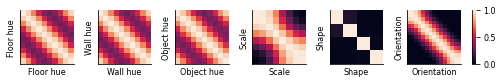

In [22]:
plot_rdms(rdms_lpl)

### LPL - Pred.off

In [23]:
rdms_pred_off, feature_mean_pred_off, feature_variance_pred_off = get_averaged_rdm(pred_off_net)

Iterating over entire dataset to get feature means and variances


  0%|          | 0/100 [00:00<?, ?it/s]

Number of features with zero variance: 0
Estimating RDMs over 10 repetitions


  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_1696758/1060392417.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


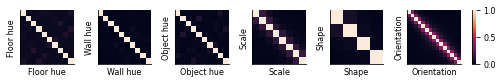

In [24]:
plot_rdms(rdms_pred_off)

### Random network

In [25]:
rdms_random, feature_mean_random, feature_variance_random = get_averaged_rdm(random_net)

Iterating over entire dataset to get feature means and variances


  0%|          | 0/100 [00:00<?, ?it/s]

Number of features with zero variance: 162
Estimating RDMs over 10 repetitions


  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_1696758/1060392417.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


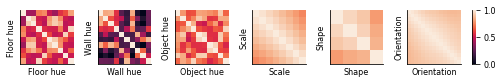

In [26]:
plot_rdms(rdms_random)

### Pixels

In [27]:
rdms_pixels, feature_mean_pixels, feature_variance_pixels = get_averaged_rdm(pixel_net)

Iterating over entire dataset to get feature means and variances


  0%|          | 0/100 [00:00<?, ?it/s]

Number of features with zero variance: 0
Estimating RDMs over 10 repetitions


  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_1696758/1060392417.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


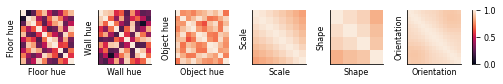

In [28]:
plot_rdms(rdms_pixels)

## Disentanglement metrics
Now, we can calculate disentanglement scores for each of the models. As reported in the paper, we'll use the metric based on a majority vote classifier from *Kim, Hyunjik, and Andriy Mnih. "Disentangling by factorising." International Conference on Machine Learning. PMLR, 2018.* This metric is implemented below.

Note: The computation can take very long. To save time, you can reduce the number of repetitions by changing the `num_reps` variable below.

In [29]:
# Reduce this number to save time
num_reps = 10

In [30]:
def process_batch_to_get_training_point(raw_batch_reprs, feature_variance):
    # normalize each feature by its standard deviation
    batch_reprs = raw_batch_reprs / (np.sqrt(feature_variance) + 1e-8)
    # get indices with zero variance
    zero_variance_indices = np.where(feature_variance == 0)[0]

    # compute variance of each feature within this batch
    batch_var = np.var(batch_reprs, axis=0)

    # find the least variable feature that has non-zero variance
    least_variable_feature = np.argmin(batch_var)
    while least_variable_feature in zero_variance_indices:
        batch_var[least_variable_feature] = np.inf
        least_variable_feature = np.argmin(batch_var)
    
    # convert to one-hot over features
    least_variable_feature_one_hot = np.zeros_like(batch_var)
    least_variable_feature_one_hot[least_variable_feature] = 1

    return least_variable_feature_one_hot


def evaluate_network(network_to_evaluate, feature_variance, batch_size=4000, num_examples_per_factor=100, exclude_colors=False):
    # get number of features
    num_features = len(feature_variance)
    majority_vote_matrix = np.zeros((num_features, len(_FACTORS_IN_ORDER)))
    for t in tqdm(range(num_examples_per_factor)):
        for factor in _FACTORS_IN_ORDER:
            if exclude_colors and factor in ['floor_hue', 'wall_hue', 'object_hue']:
                continue
            for i in range(_NUM_VALUES_PER_FACTOR[factor]):
                fixed_factor = _FACTORS_IN_ORDER.index(factor)
                # convert factor to one-hot
                factor_one_hot = np.zeros(len(_FACTORS_IN_ORDER))
                factor_one_hot[fixed_factor] = 1

                raw_batch_input = sample_random_batch(batch_size, fixed_factor=fixed_factor, fixed_factor_value=i)[0]
                raw_batch_reprs = get_features(network_to_evaluate, raw_batch_input)
                least_variable_feature_one_hot = process_batch_to_get_training_point(raw_batch_reprs, feature_variance)
                majority_vote_matrix += np.outer(least_variable_feature_one_hot, factor_one_hot)
    
    # divide each column by number of values per factor
    majority_vote_matrix /= [_NUM_VALUES_PER_FACTOR[factor] for factor in _FACTORS_IN_ORDER]
    score, strict_score = test_majority_vote_classifier(network_to_evaluate, majority_vote_matrix, feature_variance, batch_size=batch_size, num_examples_per_factor=num_examples_per_factor, exclude_colors=exclude_colors)

    return score, strict_score, majority_vote_matrix

def test_majority_vote_classifier(network_to_evaluate, majority_vote_matrix, feature_variance, batch_size=4000, num_examples_per_factor=100, exclude_colors=False):

    y_true = []
    y_pred = []
    y_pred_strict = []
    
    # create stringent majority vote classifier with only one feature per factor
    strict_majority_vote_matrix = np.zeros_like(majority_vote_matrix)
    for factor in _FACTORS_IN_ORDER:
        if exclude_colors and factor in ['floor_hue', 'wall_hue', 'object_hue']:
            continue
        factor_index = _FACTORS_IN_ORDER.index(factor)
        num_values = _NUM_VALUES_PER_FACTOR[factor]
        # get index of top num_values features for this factor
        top_feature_indices = np.argsort(majority_vote_matrix[:, factor_index])[-num_values:]
        # set these features to 1 in the strict majority vote matrix
        strict_majority_vote_matrix[top_feature_indices, factor_index] = 1

    for t in tqdm(range(num_examples_per_factor)):
        for factor in _FACTORS_IN_ORDER:
            if exclude_colors and factor in ['floor_hue', 'wall_hue', 'object_hue']:
                continue
            for i in range(_NUM_VALUES_PER_FACTOR[factor]):
                fixed_factor = _FACTORS_IN_ORDER.index(factor)
                # convert factor to one-hot
                factor_label = np.zeros(len(_FACTORS_IN_ORDER))
                factor_label[fixed_factor] = 1
                # store label in y_true
                y_true.append(np.argmax(factor_label))
                
                raw_batch_input = sample_random_batch(batch_size, fixed_factor=fixed_factor, fixed_factor_value=i)[0]
                raw_batch_reprs = get_features(network_to_evaluate, raw_batch_input)
                least_variable_feature_one_hot = process_batch_to_get_training_point(raw_batch_reprs, feature_variance)
                preds = np.dot(least_variable_feature_one_hot, majority_vote_matrix)
                strict_preds = np.dot(least_variable_feature_one_hot, strict_majority_vote_matrix)
                # if predictions are all zero, then prediction is assumed wrong
                if np.all(preds == 0):
                    y_pred.append(-1)
                else:
                    # store prediction in y_pred
                    y_pred.append(np.argmax(preds))
                
                if np.all(strict_preds == 0):
                    y_pred_strict.append(-1)
                else:
                    y_pred_strict.append(np.argmax(strict_preds))

    return accuracy_score(y_true, y_pred), accuracy_score(y_true, y_pred_strict)

In [31]:
recalculate_disentanglement = False

if recalculate_disentanglement or not os.path.exists(os.path.join(outputdir, 'disentanglement_scores.pkl')):
    disentanglement_scores = {}
    strict_disentanglement_scores = {}
    majority_vote_matrices = {}

    for net, feature_variance, name in [(lpl_net, feature_variance_lpl, 'LPL'), (pred_off_net, feature_variance_pred_off, 'Pred. off'), (random_net, feature_variance_random, 'Random'), (pixel_net, feature_variance_pixels, 'Pixels')]:
        print('Evaluating network: {}'.format(name))
        disentanglement_scores[name] = []
        majority_vote_matrices[name] = []
        strict_disentanglement_scores[name] = []
        for i in tqdm(range(num_reps)):
            disentanglement, strict_disentanglement, majority_vote_matrix = evaluate_network(net, feature_variance, batch_size=4000, num_examples_per_factor=10)
            disentanglement_scores[name].append(disentanglement)
            strict_disentanglement_scores[name].append(strict_disentanglement)
            majority_vote_matrices[name].append(majority_vote_matrix)

    import pickle

    # save disentanglement_scores and majority_vote_matrices in output directory
    with open(os.path.join(outputdir, 'disentanglement_scores.pkl'), 'wb') as f:
        pickle.dump(disentanglement_scores, f)
    with open(os.path.join(outputdir, 'strict_disentanglement_scores.pkl'), 'wb') as f:
        pickle.dump(strict_disentanglement_scores, f)
    with open(os.path.join(outputdir, 'majority_vote_matrices.pkl'), 'wb') as f:
        pickle.dump(majority_vote_matrices, f)

else:
    import pickle
    with open(os.path.join(outputdir, 'disentanglement_scores.pkl'), 'rb') as f:
        disentanglement_scores = pickle.load(f)
    with open(os.path.join(outputdir, 'strict_disentanglement_scores.pkl'), 'rb') as f:
        strict_disentanglement_scores = pickle.load(f)
    with open(os.path.join(outputdir, 'majority_vote_matrices.pkl'), 'rb') as f:
        majority_vote_matrices = pickle.load(f)

In [32]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

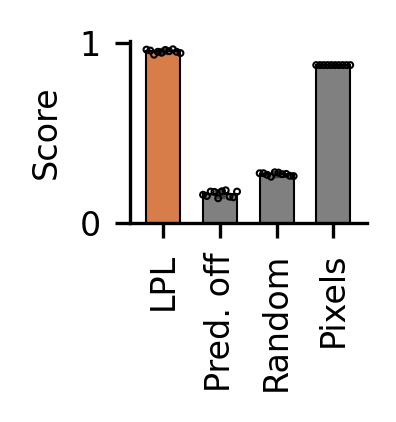

In [33]:
colors = {'LPL': '#EE7733', 'Pred. off': 'gray', 'Random': 'gray', 'Pixels': 'gray'}
barwidth = 0.6

# plot disentanglement scores as barplots with errorbars
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5), dpi=300)
import pandas as pd
# plot barplot of barwidth with errorbars
df = pd.DataFrame(disentanglement_scores)
df = df.melt(var_name='Model', value_name='Disentanglement')
sns.barplot(x='Model', y='Disentanglement', data=df, palette=colors, ax=ax, ci='sd', capsize=0.1, errwidth=1, edgecolor='black', linewidth=0.5)
change_width(ax, barwidth)
ax.set_ylabel('Score', fontsize=8)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticklabels(disentanglement_scores.keys(), rotation=90, ha='center', fontsize=8)
sns.despine()
for i, key in enumerate(disentanglement_scores.keys()):
    eps = 0.01
    x = np.linspace(i-barwidth/2, i+barwidth/2, len(disentanglement_scores[key]))
    ax.scatter(x, disentanglement_scores[key], color='black', s=2, zorder=2, marker='o', linewidth=0.5, edgecolor='black', facecolors='none')
fig.tight_layout()
fig.savefig(os.path.join(outputdir, 'disentanglement_scores.pdf'), bbox_inches='tight', backend='pgf')

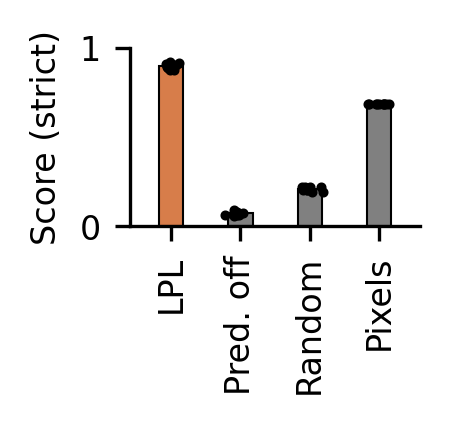

In [34]:
colors = {'LPL': '#EE7733', 'Pred. off': 'gray', 'Random': 'gray', 'Pixels': 'gray'}
barwidth = 1.0

# plot disentanglement scores as barplots with errorbars
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5), dpi=300)
import pandas as pd
# plot barplot of barwidth with errorbars
df = pd.DataFrame(strict_disentanglement_scores)
df = df.melt(var_name='Model', value_name='Disentanglement')
sns.barplot(x='Model', y='Disentanglement', data=df, palette=colors, ax=ax, ci='sd', capsize=0.1, errwidth=1, edgecolor='black', linewidth=0.5)
change_width(ax, .35)
ax.set_ylabel('Score (strict)', fontsize=8)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_yticks([0, 1])
ax.set_ylim([0, 1])
ax.set_xticklabels(strict_disentanglement_scores.keys(), rotation=90, ha='center', fontsize=8)
sns.despine()
for i, key in enumerate(strict_disentanglement_scores.keys()):
    x = np.random.normal(i, 0.08, size=len(strict_disentanglement_scores[key]))
    ax.scatter(x, strict_disentanglement_scores[key], color='black', s=2, zorder=2)
fig.tight_layout()
fig.savefig(os.path.join(outputdir, 'strict_disentanglement_scores.pdf'), bbox_inches='tight', backend='pgf')

In [35]:
# print average disentanglement scores and standard deviations
for name in disentanglement_scores:
    print('{}: {} +- {}'.format(name, 100*np.mean(disentanglement_scores[name]), 100*np.std(disentanglement_scores[name])))

LPL: 95.28070175438597 +- 0.8995399118101228
Pred. off: 16.228070175438596 +- 1.5419645466006096
Random: 27.140350877192983 +- 0.8003154195057568
Pixels: 87.71929824561401 +- 1.1102230246251565e-14


In [36]:
# print average strict disentanglement scores and standard deviations
for name in strict_disentanglement_scores:
    print('{}: {} +- {}'.format(name, 100*np.mean(strict_disentanglement_scores[name]), 100*np.std(strict_disentanglement_scores[name])))

LPL: 89.91228070175438 +- 1.4322710745183052
Pred. off: 7.175438596491228 +- 1.0122366131053797
Random: 20.842105263157894 +- 1.0922373625455002
Pixels: 68.42105263157895 +- 0.0


In [37]:
# count number of rows in majority vote matrix that are all zeros
for name in majority_vote_matrices:
    num_zero_rows = np.sum(np.sum(majority_vote_matrices[name], axis=(0,2)) == 0)
    print('Number of zero rows in majority vote matrix for {}: {}'.format(name, num_zero_rows))

Number of zero rows in majority vote matrix for LPL: 411
Number of zero rows in majority vote matrix for Pred. off: 17
Number of zero rows in majority vote matrix for Random: 500
Number of zero rows in majority vote matrix for Pixels: 12275


In [38]:
# for each factor, find features with non-zero weights in summed majority vote matrix in any of the runs, store them in a list
feature_factor_indices = {}
for name in majority_vote_matrices:
    feature_factor_indices[name] = {}
    summed_majority_vote_matrix = np.sum(majority_vote_matrices[name], axis=0)
    for factor in _FACTORS_IN_ORDER:
        feature_factor_indices[name][factor] = np.where(summed_majority_vote_matrix != 0)[0]

##  Manifold visualization

In [39]:
def disentanglement_plots_pca(factor, factor_to_covary=None):

    fixed_factors = np.array([np.random.choice(_NUM_VALUES_PER_FACTOR[f]) for f in _FACTORS_IN_ORDER])
    img_batch1, factors = sample_batch_varying_one_factor(factor, fixed_factors)

    # get another batch of images with the same fixed_factors except for a random factor other than the one we're varying
    factor_to_change = np.random.choice([f for f in _FACTORS_IN_ORDER if f != factor]) if factor_to_covary is None else factor_to_covary
    fixed_factors[_FACTORS_IN_ORDER.index(factor_to_change)] = np.random.choice(_NUM_VALUES_PER_FACTOR[factor_to_change])
    img_batch2, _ = sample_batch_varying_one_factor(factor, fixed_factors)

    # print name factor_to_change
    print('Factor changed: {}'.format(factor_to_change))

    # concatenate the two batches
    img_batch = np.concatenate([img_batch1, img_batch2], axis=0)

    # get representations of the images in batch
    for name, network in [('LPL', lpl_net), ('Pred. off', pred_off_net), ('Random', random_net), ('Pixels', pixel_net)]:
        # get representations of the images in batch
        representations = get_features(network, img_batch)

        # get PCA of representations
        pca = PCA(n_components=2)
        representations_pca = pca.fit_transform(representations)
        pca_variance = pca.explained_variance_ratio_
        print('PCA of {} representations (variance explained: {:.2f}%)'.format(name, np.sum(pca_variance) * 100))

        # plot PCA of representations
        fig, ax = plt.subplots(1, 1, figsize=(1.2, 1.2), dpi=150)
        ax.scatter(representations_pca[:img_batch1.shape[0], 0], representations_pca[:img_batch1.shape[0], 1], color='#555555', s=4, zorder=3)
        ax.scatter(representations_pca[img_batch1.shape[0]:, 0], representations_pca[img_batch1.shape[0]:, 1], color='#AAAAAA', s=4, zorder=4)
        # connect consecutive points in each of the two batches with lines
        for i in range(img_batch1.shape[0] - 1):
            ax.plot([representations_pca[i, 0], representations_pca[i + 1, 0]], [representations_pca[i, 1], representations_pca[i + 1, 1]], color='#555555', linewidth=1, zorder=1)
        for i in range(img_batch1.shape[0], img_batch.shape[0] - 1):
            ax.plot([representations_pca[i, 0], representations_pca[i + 1, 0]], [representations_pca[i, 1], representations_pca[i + 1, 1]], color='#AAAAAA', linewidth=1, zorder=2)
        # ax.set_title(name, fontsize=8)
        # ax.set_xlabel('PC 1', fontsize=8)
        # ax.set_ylabel('PC 2', fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        fig.tight_layout()
        fig.savefig(os.path.join(outputdir, 'disentanglement_plots_pca_{}_{}.pdf'.format(name, factor)), bbox_inches='tight', backend='pgf')

You might need to run the following cell a couple of times until you get a good visualization. The visualization is done using the PCA algorithm with stochastic data sampling, which sometimes gives a side-view of the desired manifold. The visualization is in 2D, so it is likely that the desired view is not always obtained as one of the first two principal components. However, you will observe that the manifolds are always entangled except for LPL.

Factor changed: scale
PCA of LPL representations (variance explained: 68.67%)
PCA of Pred. off representations (variance explained: 15.92%)
PCA of Random representations (variance explained: 62.54%)
PCA of Pixels representations (variance explained: 81.95%)


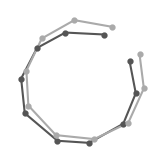

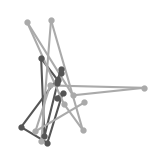

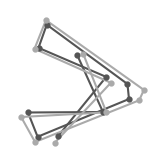

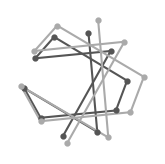

In [40]:
disentanglement_plots_pca('object_hue', factor_to_covary='scale')

In [41]:
# get a random batch of images
raw_batch_input, factors = sample_random_batch(4000)

In [42]:
pred_off_net_reprs = get_features(pred_off_net, raw_batch_input)
random_net_reprs = get_features(random_net, raw_batch_input)
lpl_net_reprs = get_features(lpl_net, raw_batch_input)
pixel_net_reprs = get_features(pixel_net, raw_batch_input)

In [43]:
# do pca on representations
lpl_pca = PCA(n_components=2).fit_transform(lpl_net_reprs)
pixel_pca = PCA(n_components=20).fit_transform(pixel_net_reprs)
random_pca = PCA(n_components=2).fit_transform(random_net_reprs)

In [44]:
def make_scatter_plots(pca_projections, savefig=False, label='lpl'):
    # scatter plots of pca representations of images with color corresponding to each factor
    fig, axes = plt.subplots(1, 6, figsize=(6.8, 1.5), dpi=200)
    for i, factor in enumerate(_FACTORS_IN_ORDER):
        axes[i].scatter(pca_projections[:,0], pca_projections[:,1], c=factors[i], cmap='tab10', label=factor, s=1)
        axes[i].set_title(refine_title(factor))
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        axes[i].set_frame_on(False)

    plt.tight_layout()
    if savefig:
        # save the figure
        plt.savefig(os.path.join(outputdir, 'pca_scatter_{}.png'.format(label)), bbox_inches='tight', dpi=300)

### LPL

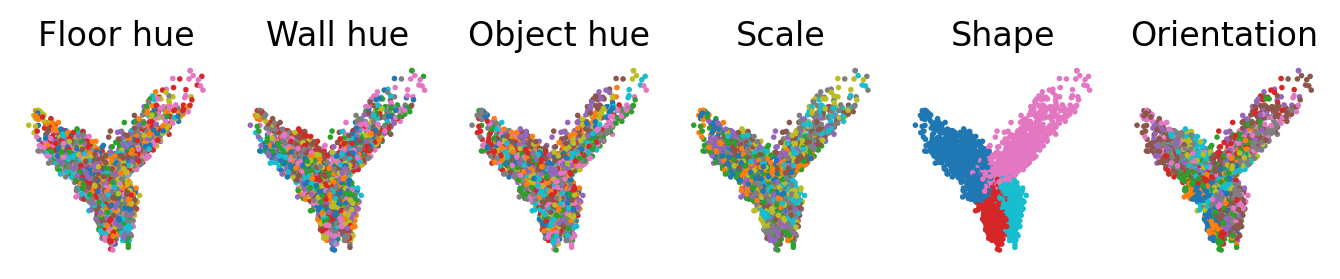

In [45]:
make_scatter_plots(lpl_pca)

### Pixels

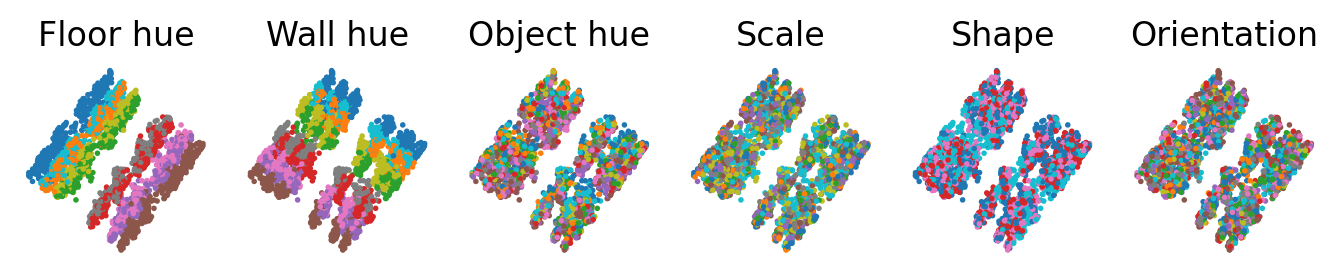

In [46]:
make_scatter_plots(pixel_pca, label='pixel')

### Random network

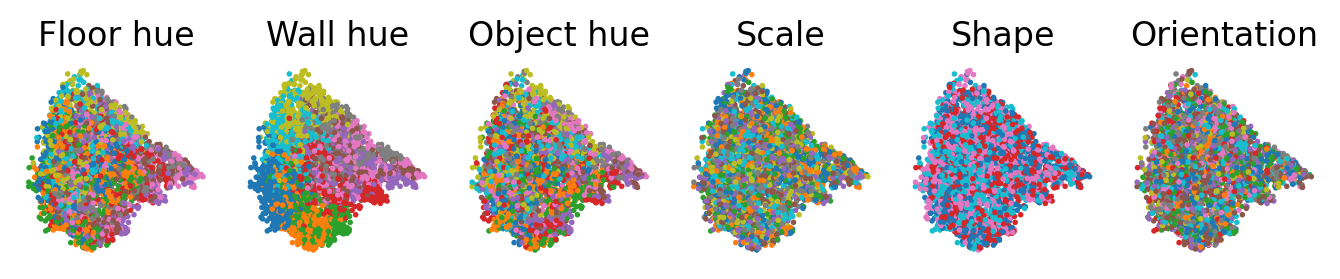

In [47]:
make_scatter_plots(random_pca, label='random')